<a href="https://colab.research.google.com/github/Kushagra3219/CNN-Models/blob/main/yolov4_webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv4 Object Detection on Webcam In Google Colab
This notebook will walkthrough all the steps for performing YOLOv4 object detections on your webcam while in Google Colab. We will be using scaled-YOLOv4 (yolov4-csp) for this tutorial, the fastest and most accurate object detector there currently is.

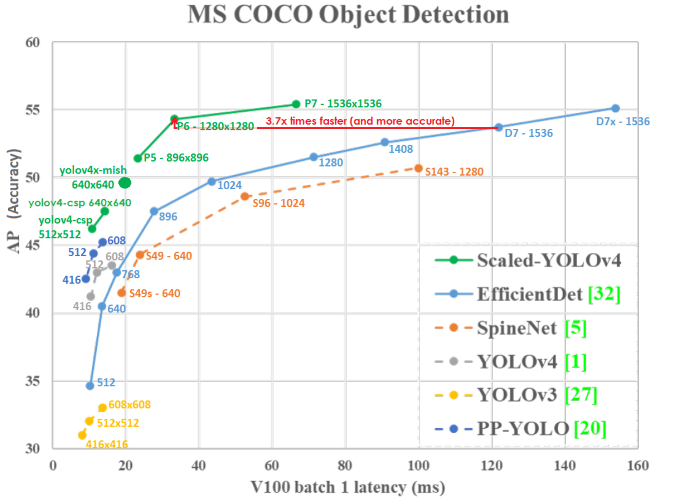

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Cloning and Setting Up Darknet for YOLOv4
We will be using the famous AlexeyAB's darknet repository in this tutorial to perform YOLOv4 detections.

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

In [5]:
# get the scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!pip install gdown --quiet
!gdown --id 1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq -O yolov4-csp.weights

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
From (redirected): https://drive.google.com/uc?id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq&confirm=t&uuid=a4e54f26-b005-4f48-8616-d8b587948052
To: /content/darknet/yolov4-csp.weights
100% 212M/212M [00:05<00:00, 38.7MB/s]


## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation. Feel free to checkout the darknet.py file to see the function definitions in detail!

In [6]:
%cd /content


/content


In [7]:
import cv2
!ls /content



darknet  sample_data


In [8]:
!ls /content | grep darknet || git clone https://github.com/AlexeyAB/darknet


darknet


In [9]:
# ---------- DARKNET SETUP CELL ----------
import os, sys

# always start from /content
os.chdir("/content")

# clone darknet if missing
if not os.path.exists("/content/darknet"):
    !git clone https://github.com/AlexeyAB/darknet

# compile darknet if needed
os.chdir("/content/darknet")

# Ensure Makefile is correctly configured for shared library
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

if not os.path.exists("libdarknet.so"):
    !apt-get update -qq # Update package lists
    !apt-get install -y libopencv-dev # Install OpenCV development files
    # Explicitly build the shared library target
    !make -j8 libdarknet.so || make -j8

# Verify libdarknet.so is created and in the current directory
!ls -l /content/darknet/libdarknet.so || echo "libdarknet.so not found after make"

# tell python where darknet lives
sys.path.insert(0, "/content/darknet/python")
os.environ["LD_LIBRARY_PATH"] = "/content/darknet"

# Import darknet functions after paths are set
from darknet import *

print("Darknet ready")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core gsettings-desktop-schemas gstreamer1.0-plugins-base
  libatk-bridge2.0-0 libatk1.0-0 libatk1.0-data libatspi2.0-0 libavcodec-dev
  libavformat-dev libavutil-dev libcdparanoia0 libcharls2 libdc1394-dev
  libdouble-conversion3 libexif-dev libexif-doc libexif12 libgdcm-dev
  libgdcm3.0 libgl2ps1.4 libglew2.2 libgphoto2-6 libgphoto2-dev
  libgphoto2-l10n libgphoto2-port12 libgstreamer-plugins-base1.0-0 libgtk-3-0
  libgtk-3-bin libgtk-3-common libilmbase-dev libilmbase25
  libopencv-calib3d-dev libopencv-calib3d4.5d libopencv-contrib-dev
  libopencv-contrib4.5d libopencv-core-dev libopencv-core4.5d
  libopencv-dnn-dev libopencv-dnn4.5d libope

In [10]:
import darknet
print([f for f in dir(darknet) if "load" in f])



['__loader__', 'load_image', 'load_meta', 'load_net', 'load_net_custom', 'load_network']


In [11]:
import sys, os

sys.path.insert(0, "/content/darknet")
os.environ["LD_LIBRARY_PATH"] = "/content/darknet"

import darknet


In [12]:
import darknet
print("Darknet imported successfully")


Darknet imported successfully


In [13]:
# import darknet functions to perform object detections
# from darknet import * # This import is now handled in the setup cell
import os
import random # Import random for color generation

# Helper function to load the network, class names, and class colors
def load_network(config_file, weights_file, data_file, batch_size=1):
    network = darknet.load_net_custom(config_file.encode('ascii'), weights_file.encode('ascii'), 0, batch_size)  # batch_size=1

    # Read the data file to find the names file
    with open(data_file, 'r') as f:
        data_content = f.read()
    names_relative_path = ''
    for line in data_content.splitlines():
        if line.startswith('names ='):
            names_relative_path = line.split('=')[1].strip()
            break
    if not names_relative_path:
        raise ValueError("Names file not found in data_file")

    # Construct absolute path for the names file relative to darknet root
    darknet_root = os.path.dirname(config_file) # Get parent of cfg, which is darknet root
    if not darknet_root.endswith('darknet'):
        darknet_root = os.path.join(darknet_root, '..') # Adjust if cfg is directly in darknet
    names_file_abs_path = os.path.join(darknet_root, names_relative_path)

    # Load class names from the names file
    with open(names_file_abs_path, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]

    # Custom make_colors function if darknet.make_colors is not available
    def make_colors_custom(num_colors):
        return [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(num_colors)]

    class_colors = make_colors_custom(len(class_names))
    return network, class_names, class_colors

# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("/content/darknet/cfg/yolov4-csp.cfg", "/content/darknet/yolov4-csp.weights", "/content/darknet/cfg/coco.data")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## YOLOv4 Example on Test Image
Let's make sure our model has successfully been loaded and that we can make detections properly on a test image.

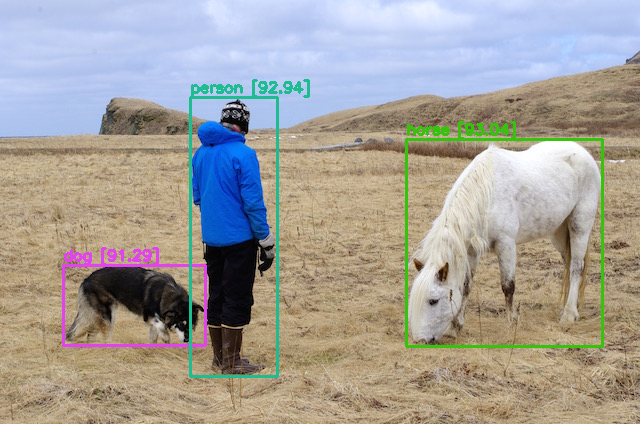

In [14]:
# run test on person.jpg image that comes with repository
image = cv2.imread("data/person.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  # Find the integer index of the label string in class_names
  label_index = class_names.index(label)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label_index], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label_index], 2)
cv2_imshow(image)

## Helper Functions
Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [15]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4 on Wecam Images
Running YOLOv4 on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** which runs JavaScript code to utilize your computer's webcam. The code snippet will take a webcam photo, which we will then pass into our YOLOv4 model for object detection.

Below is a function to take the webcam picture using JavaScript and then run YOLOv4 on it.

In [16]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);m
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

## YOLOv4 on Webcam Videos
Running YOLOv4 on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our YOLOv4 model and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

YOLOv4 is so fast that it can run the detections in real-time!

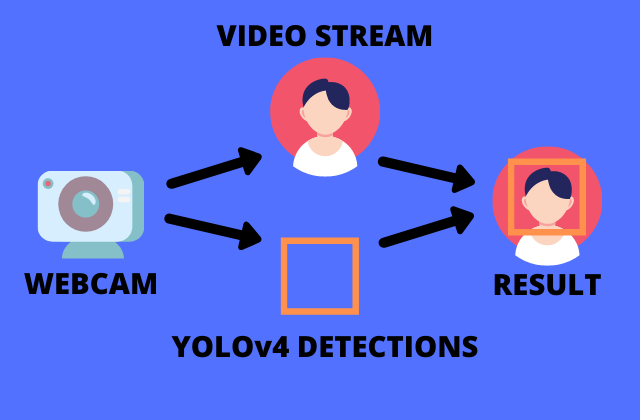

Below is a function to start up the video stream using similar JavaScript as was used for images. The video stream frames are fed as input to YOLOv4.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      # Find the integer index of the label string in class_names
      label_index = class_names.index(label)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label_index], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label_index], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

## Hope You Enjoyed!
If you enjoyed the tutorial and want to see more videos or tutorials check out my YouTube channel [HERE](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q?sub_confirmation=1)

Have a great day!